# Udacity Machine Learning Capstone Project
## Image Classification on the Yelp! Dataset using CNN and Transfer learning
** Part 3: Identifying the type of drink present in the image **

In [1]:
# Importing all the required libraries
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import glob
from time import time
import os
import cv2
import seaborn as sns
import json
from collections import Counter
import itertools

In [4]:
# Get all the paths of drinks from the 'drinks' folder
drinks_paths = glob.glob('./drinks/*/*')

In [5]:
# Get the respective labels of the food from it's paths
drink_labels = list()
for path in drinks_paths:
     drink_labels.append(path.split('/')[2])

In [6]:
# Get the index of all the types of drinks
drink_index = {drink:k for k, drink in enumerate(set(drink_labels))}
drink_index

{'beer': 0, 'milkshake': 1, 'wine': 2}

In [8]:
# Define function to one hot encode the labels as well as get drink from labels
''' 0. beer
    1. milkshake
    2. wine
'''

def get_drink_label(label, drink_index):
    if (label == 'beer'):
        in_array = np.zeros(len(drink_index))
        in_array[drink_index['beer']] = 1
        return in_array
    elif (label == 'milkshake'):
        in_array = np.zeros(len(drink_index))
        in_array[drink_index['milkshake']] = 1
        return in_array
    elif (label == 'wine'):
        in_array = np.zeros(len(drink_index))
        in_array[drink_index['wine']] = 1
        return in_array
    
def get_drink(label):
    
    if (label == 0):
        return 'beer'
    elif (label == 1):
        return 'milkshake'
    elif (label == 2):
        return 'wine'

In [9]:
# One hot encode the labels
one_hot_lables = list()
for label in drink_labels:
    one_hot_lables.append(list(get_drink_label(label, drink_index)))

### Splitting data into Training, Testing and Cross Validation datasets

The dataset is split into training data which comprises of 80% of data, cross validation data into 10% and testing data into 10%

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_buff, y_train, y_buff = train_test_split(drinks_paths, one_hot_lables, stratify=drink_labels, train_size=0.8)
x_val, x_test, y_val, y_test = train_test_split(x_buff, y_buff, stratify=y_buff, train_size=0.5)

print "Number of training data: ", len(x_train)
print "Number of cross validation data: ", len(x_val)
print "Number of testing data: ", len(x_test)

Number of training data:  1368
Number of cross validation data:  171
Number of testing data:  171


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [11]:
from keras.preprocessing import image

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

Using TensorFlow backend.


In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(x_train).astype('float32')/255
valid_tensors = paths_to_tensor(x_val).astype('float32')/255
test_tensors = paths_to_tensor(x_test).astype('float32')/255

## Training Phase

### 1. Simple CNN with 5 hidden layerz

In [15]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten, Dense, Dropout
from keras.models import Sequential, optimizers

model_cnn5 = Sequential()

model_cnn5.add(Conv2D(filters=16, kernel_size=4, padding='same', activation='relu', input_shape=(224,224,3)))
model_cnn5.add(Dropout(0.3))
model_cnn5.add(MaxPooling2D(pool_size=2))

model_cnn5.add(Conv2D(filters=32, kernel_size=4, padding='same', activation='relu'))
model_cnn5.add(Dropout(0.3))
model_cnn5.add(MaxPooling2D(pool_size=2))

model_cnn5.add(Conv2D(filters=64, kernel_size=4, padding='same', activation='relu'))
model_cnn5.add(Dropout(0.3))
model_cnn5.add(MaxPooling2D(pool_size=2))

model_cnn5.add(Conv2D(filters=128, kernel_size=4, padding='same', activation='relu'))
model_cnn5.add(Dropout(0.3))
model_cnn5.add(MaxPooling2D(pool_size=2))

model_cnn5.add(Conv2D(filters=256, kernel_size=4, padding='same', activation='relu'))
model_cnn5.add(Dropout(0.3))
model_cnn5.add(MaxPooling2D(pool_size=2))

model_cnn5.add(GlobalAveragePooling2D())

model_cnn5.add(Dense(128, activation='relu'))
model_cnn5.add(Dropout(0.3))
model_cnn5.add(Dense(64, activation='relu'))
model_cnn5.add(Dropout(0.3))
model_cnn5.add(Dense(3, activation='softmax'))

model_cnn5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 16)      784       
_________________________________________________________________
dropout_8 (Dropout)          (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      8224      
_________________________________________________________________
dropout_9 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        32832     
__________

In [16]:
from keras.callbacks import ModelCheckpoint

model_cnn5.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 20

checkpointer = ModelCheckpoint(filepath='final_weights/weights.best.drinks_cnn_5.hdf5', 
                               verbose=1, save_best_only=True)

history_drinks_cnn5 = model_cnn5.fit(train_tensors, y_train, 
          validation_data=(valid_tensors, y_val),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 1368 samples, validate on 171 samples
Epoch 1/20
1368/1368 [==============================] - 11s - loss: 1.0651 - acc: 0.5000 - val_loss: 0.9414 - val_acc: 0.5965
Epoch 2/20
1368/1368 [==============================] - 8s - loss: 0.8901 - acc: 0.5768 - val_loss: 0.8485 - val_acc: 0.5965
Epoch 3/20
1368/1368 [==============================] - 8s - loss: 0.8132 - acc: 0.6462 - val_loss: 0.9178 - val_acc: 0.6257
Epoch 4/20
1368/1368 [==============================] - 8s - loss: 0.7992 - acc: 0.6791 - val_loss: 0.8666 - val_acc: 0.6082
Epoch 5/20
1368/1368 [==============================] - 8s - loss: 0.7414 - acc: 0.6988 - val_loss: 0.9977 - val_acc: 0.5673
Epoch 6/20
1368/1368 [==============================] - 8s - loss: 0.7103 - acc: 0.7135 - val_loss: 0.7378 - val_acc: 0.7193
Epoch 7/20
1368/1368 [==============================] - 8s - loss: 0.7048 - acc: 0.7259 - val_loss: 1.1725 - val_acc: 0.4444
Epoch 8/20
1368/1368 [==============================] - 8s - loss: 0.6951 - a

#### Training plots for CNN with 5 hidden layers

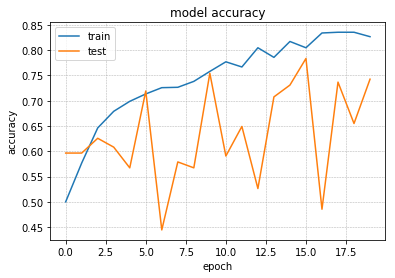

In [18]:
plt.plot(history_drinks_cnn5.history['acc'])
plt.plot(history_drinks_cnn5.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

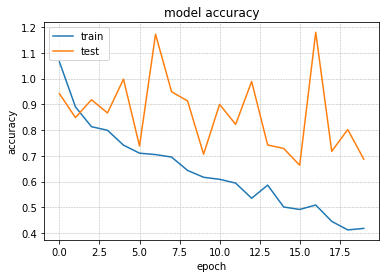

In [19]:
plt.plot(history_drinks_cnn5.history['loss'])
plt.plot(history_drinks_cnn5.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

#### Test Accuracy on CNN with 5 hidden layers

In [20]:
score_cnn5 = 0
for k,path in enumerate(x_test):
    pred_ = np.argmax(model_cnn5.predict(paths_to_tensor([path]).astype('float32')/255))
    if (pred_==np.argmax(y_test[k])):
        score_cnn5=score_cnn5+1
        
print "Testing Accuracy on 5 layer CNN: ", float(score_cnn5)/len(x_test)

Testing Accuracy on 5 layer CNN:  0.754385964912


### 2. Transfer Learning: VGG19

In [21]:
from keras.applications import VGG19
from keras.models import Model
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))

#for layer in vgg19_model.layers[:5]:
#    layer.trainable = False
    
x = vgg19_model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation="softmax")(x)
model_vgg19 = Model(inputs=vgg19_model.input, outputs=predictions)
model_vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [22]:
from keras.callbacks import ModelCheckpoint

model_vgg19.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), 
                    loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 10

checkpointer = ModelCheckpoint(filepath='final_weights/weights.best.drinks_vgg19.hdf5',
                              verbose=1, save_best_only=True)

history_drinks_vgg19 = model_vgg19.fit(train_tensors, y_train,
                              validation_data=(valid_tensors, y_val),
                              epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 1368 samples, validate on 171 samples
Epoch 1/10
1368/1368 [==============================] - 131s - loss: 1.0786 - acc: 0.4656 - val_loss: 0.6972 - val_acc: 0.7427
Epoch 2/10
1368/1368 [==============================] - 124s - loss: 0.6048 - acc: 0.7420 - val_loss: 0.4173 - val_acc: 0.8246
Epoch 3/10
1368/1368 [==============================] - 124s - loss: 0.3701 - acc: 0.8414 - val_loss: 0.3329 - val_acc: 0.8772
Epoch 4/10
1368/1368 [==============================] - 124s - loss: 0.2382 - acc: 0.9086 - val_loss: 0.2850 - val_acc: 0.8830
Epoch 5/10
1368/1368 [==============================] - 124s - loss: 0.1830 - acc: 0.9320 - val_loss: 0.2836 - val_acc: 0.8713
Epoch 6/10
1368/1368 [==============================] - 124s - loss: 0.1152 - acc: 0.9678 - val_loss: 0.2201 - val_acc: 0.9240
Epoch 7/10
1368/1368 [==============================] - 122s - loss: 0.0737 - acc: 0.9744 - val_loss: 0.2525 - val_acc: 0.9181
Epoch 8/10
1368/1368 [==============================] - 122s - l

#### Testing accuracy for VGG19

In [23]:
score_vgg19 = 0
for k,path in enumerate(x_test):
    pred_ = np.argmax(model_vgg19.predict(paths_to_tensor([path]).astype('float32')/255))
    if (pred_==np.argmax(y_test[k])):
        score_vgg19=score_vgg19+1
        
print "Testing Accuracy on 5 layer CNN: ", float(score_vgg19)/len(x_test)

Testing Accuracy on 5 layer CNN:  0.912280701754


### 2. Transfer Learning: ResNet50

In [26]:
from keras.applications import ResNet50
from keras.models import Model
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

#for layer in vgg19_food.layers[:3]:
#    layer.trainable = False
    
x = resnet_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation="softmax")(x)
model_resnet50 = Model(inputs=resnet_model.input, outputs=predictions)

model_resnet50.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_3[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_50 (Activation)       (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [29]:
from keras.callbacks import ModelCheckpoint

model_resnet50.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), 
                           loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 20

checkpointer = ModelCheckpoint(filepath='final_weights/weights.best.drinks_resnet50.hdf5',
                              verbose=1, save_best_only=True)

history_resnet50 = model_resnet50.fit(train_tensors, y_train,
                              validation_data=(valid_tensors, y_val),
                              epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 1368 samples, validate on 171 samples
Epoch 1/20
1368/1368 [==============================] - 55s - loss: 0.0984 - acc: 0.9700 - val_loss: 0.2025 - val_acc: 0.9357
Epoch 2/20
1368/1368 [==============================] - 53s - loss: 0.0918 - acc: 0.9751 - val_loss: 0.1768 - val_acc: 0.9240
Epoch 3/20
1368/1368 [==============================] - 53s - loss: 0.0818 - acc: 0.9810 - val_loss: 0.1711 - val_acc: 0.9298
Epoch 4/20
1368/1368 [==============================] - 53s - loss: 0.0721 - acc: 0.9825 - val_loss: 0.1702 - val_acc: 0.9415
Epoch 5/20
1368/1368 [==============================] - 51s - loss: 0.0710 - acc: 0.9846 - val_loss: 0.1740 - val_acc: 0.9357
Epoch 6/20
1368/1368 [==============================] - 53s - loss: 0.0627 - acc: 0.9883 - val_loss: 0.1680 - val_acc: 0.9474
Epoch 7/20
1368/1368 [==============================] - 53s - loss: 0.0622 - acc: 0.9839 - val_loss: 0.1644 - val_acc: 0.9415
Epoch 8/20
1368/1368 [==============================] - 53s - loss: 0.0

#### Testing accuracy for ResNet50

In [30]:
score_resnet50 = 0
for k,path in enumerate(x_test):
    pred_ = np.argmax(model_resnet50.predict(paths_to_tensor([path]).astype('float32')/255))
    if (pred_==np.argmax(y_test[k])):
        score_resnet50=score_resnet50+1
        
print "Testing Accuracy on ResNet50 architecture: ", float(score_resnet50)/len(x_test)

Testing Accuracy on ResNet50 architecture:  0.953216374269


### Performance on the trained CNN architectures

**CNN with 5 layers:** 75.43%

**VGG19:** 91.22%

**ResNet50:** 95.32%

We see that ResNet50 performs the best on the given dataset, and since ResNet is known to give the best results, I have chosen not to train on other CNN architectures such as InceptionV3 and Xception (just to save time on AWS server and ResNet has proven to provide better performance that these architectures in the previous sections). Thus, I have chosen ResNet50 and it's weight as my architecture for the application

### Confusion Matrix (On ResNet50 model)

In [31]:
from sklearn.metrics import confusion_matrix

predictions_resnet50 = list()
false_prediction_resnet50_path = list()
false_prediction_resnet50_pred = list()
false_prediction_resnet50_actual = list()
for k,path in enumerate(x_test):
    pred_ = np.argmax(model_resnet50.predict(paths_to_tensor([path]).astype('float32')/255))
    predictions_resnet50.append(pred_)
    if (pred_!=np.argmax(y_test[k])):
        false_prediction_resnet50_path.append(x_test[k])
        false_prediction_resnet50_pred.append(pred_)
        false_prediction_resnet50_actual.append(np.argmax(y_test[k]))
    
test_labels = list()
for ele in y_test:
    test_labels.append(np.argmax(ele))

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

Confusion matrix, without normalization


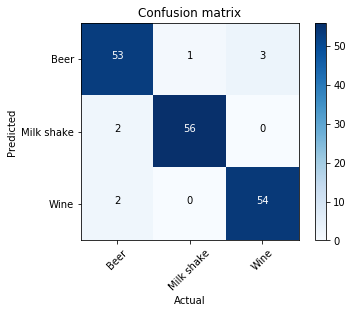

In [33]:
cmf_resnet50 = confusion_matrix(predictions_resnet50, test_labels)
plt.figure()
plot_confusion_matrix(cmf_resnet50, 
                      classes=['Beer', 'Milk shake', 'Wine'])
plt.show()

We can see that 'Beer' and 'Wine' are sometimes misclassified owing to the similarity of the drinks in terms of color. (Some beer are as dark as red wine)

## Understanding false predictions

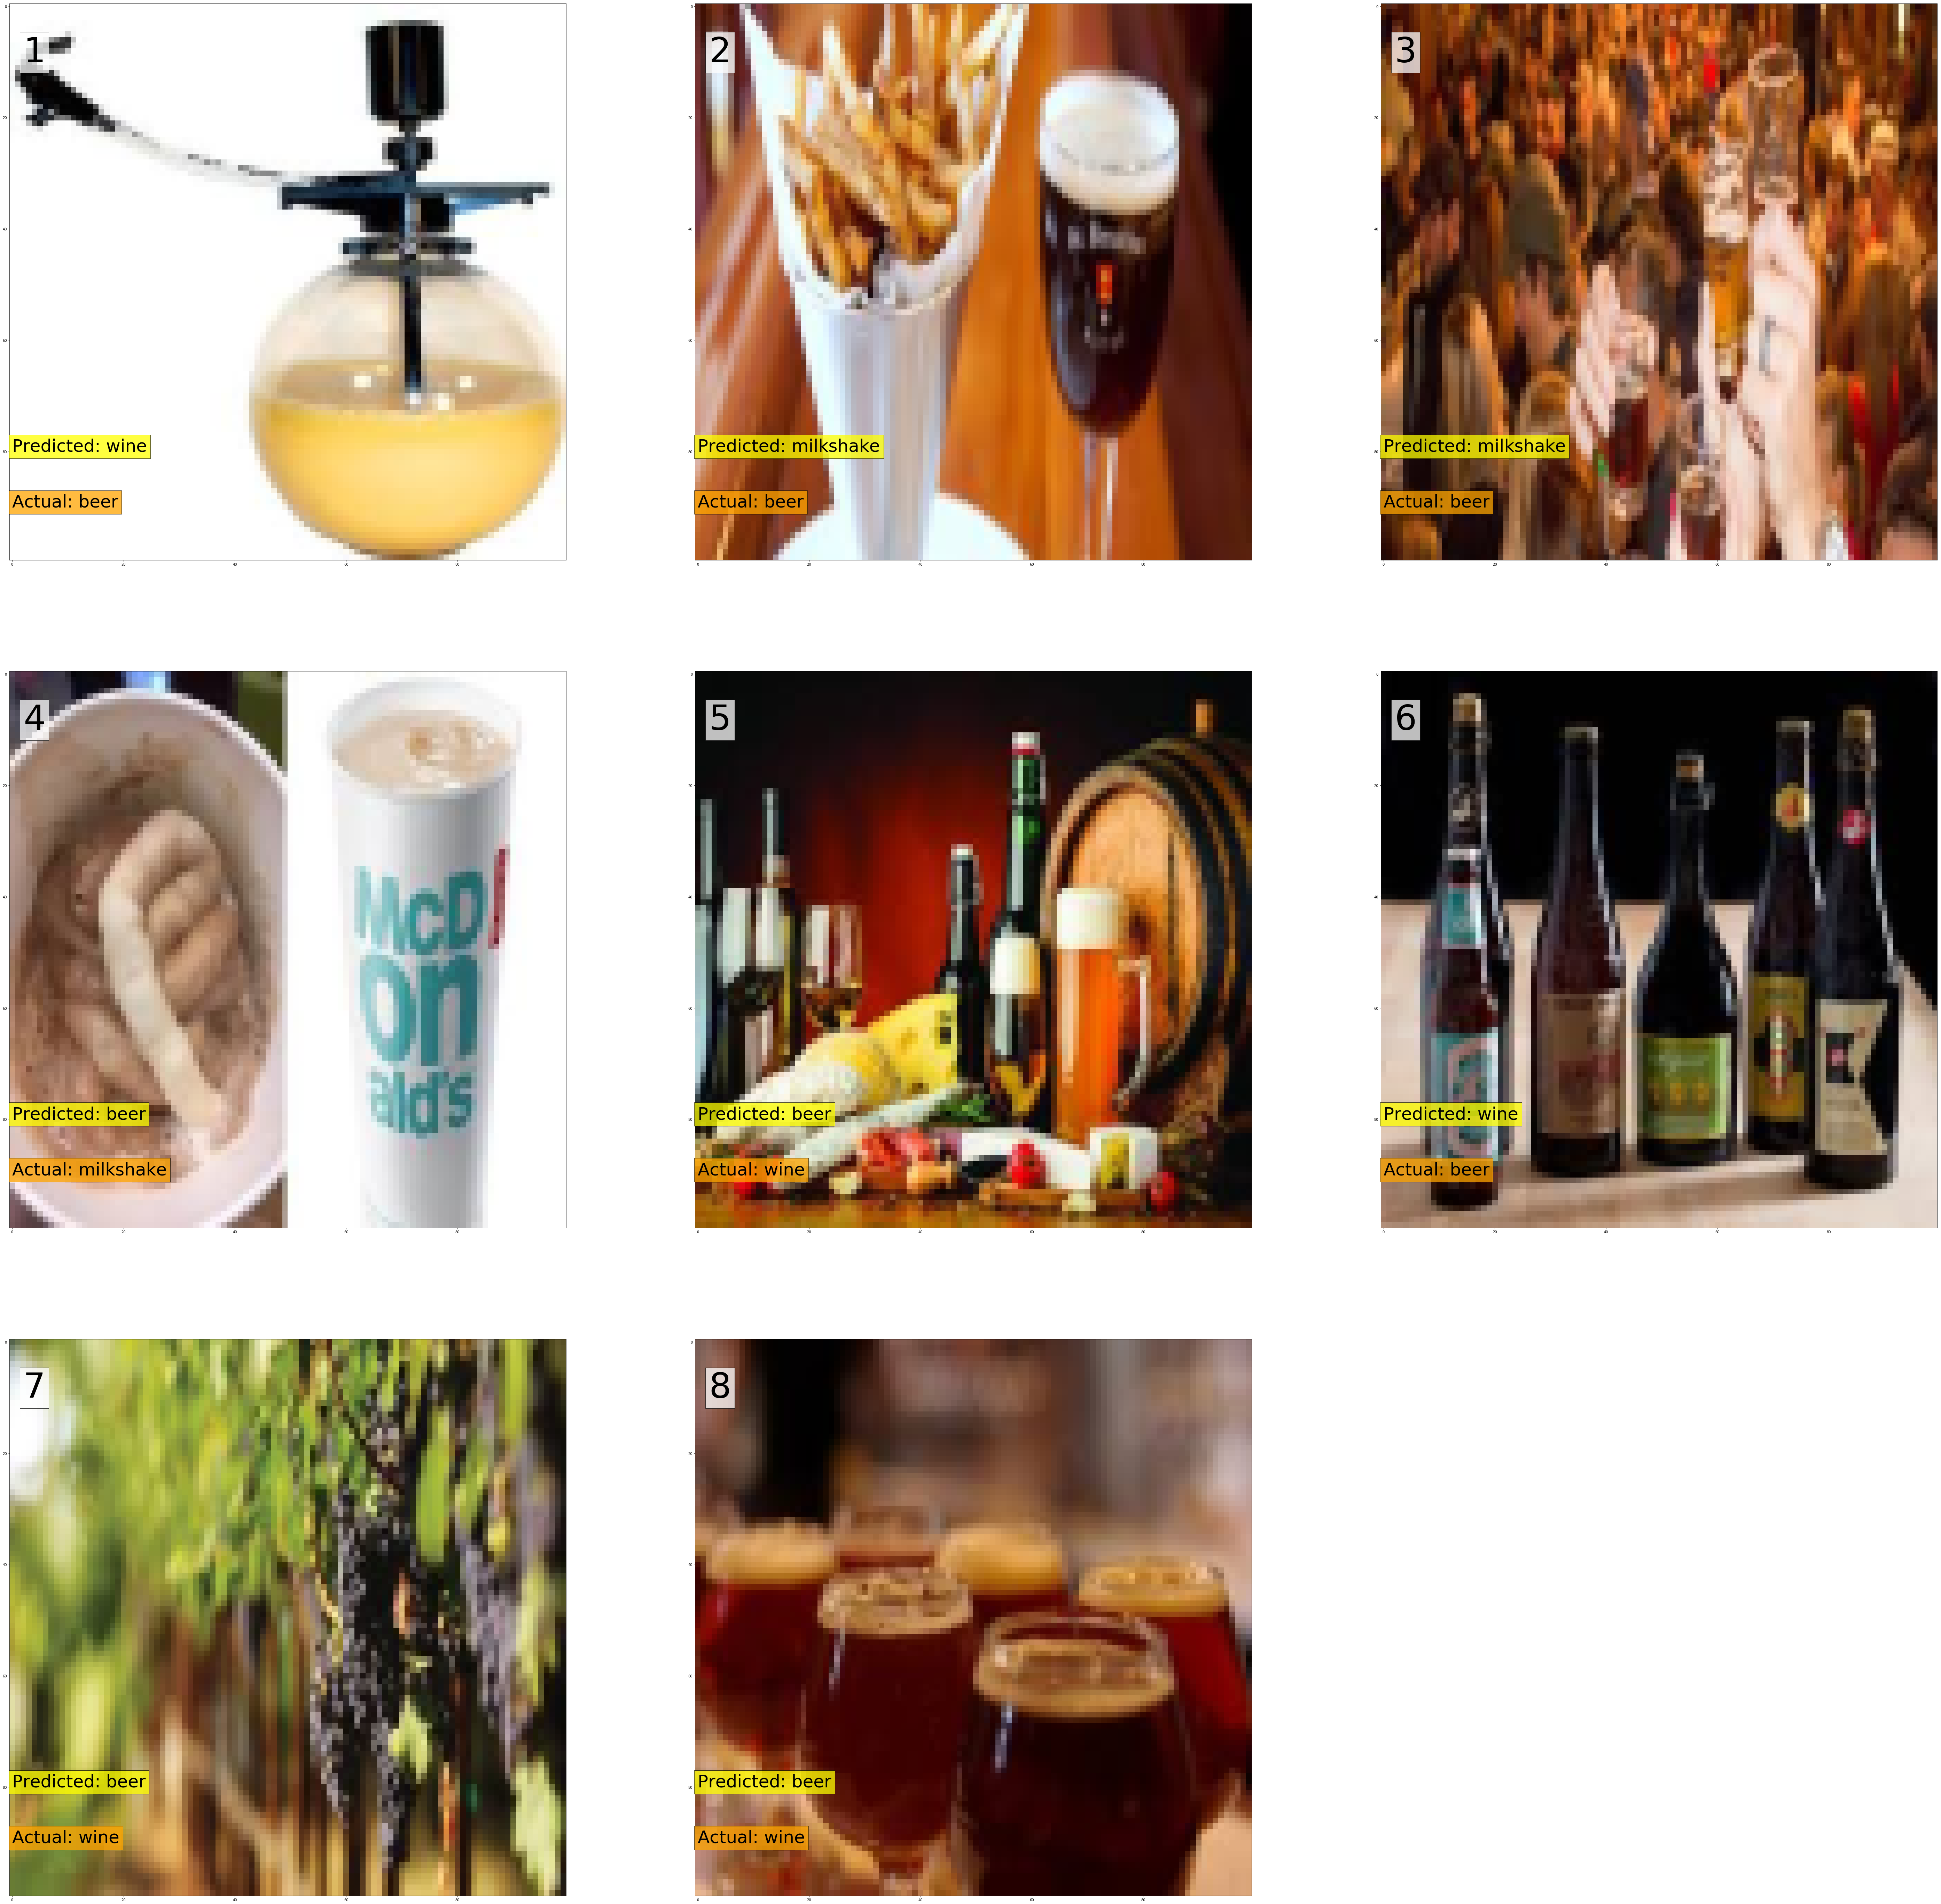

In [40]:
fig=plt.figure(figsize=(100, 100))
columns = 3
rows = 3
for k,path in enumerate(false_prediction_resnet50_path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (100,100), interpolation = cv2.INTER_AREA)
    cv_rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    ax = fig.add_subplot(rows, columns, k+1)
    ax.text(2, 10, str(k+1), size=100, 
            bbox={'facecolor':'white', 'alpha':0.75, 'pad':10})
    ax.text(0, 80, 'Predicted: '+get_food(false_prediction_resnet50_pred[k]), size=50, 
            bbox={'facecolor':'yellow', 'alpha':0.75, 'pad':10})
    ax.text(0, 90, 'Actual: '+get_food(false_prediction_resnet50_actual[k]), size=50, 
            bbox={'facecolor':'orange', 'alpha':0.75, 'pad':10})
    plt.imshow(cv_rgb)
plt.show()

This is largely the fault when collecting the dataset. Images 1,3 and 7 have incorrect images. Image 6 looks like a wine bottle.

### Performance of the model on few of the 'Yelp' dataset Images

In [48]:
# Get prediction and display the label along with images
def get_prediction(path):    
    img = cv2.imread(path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, channels = np.shape(cv_rgb)
    plt.imshow(cv_rgb)
    pred_ = np.argmax(model_resnet50.predict(paths_to_tensor([path]).astype('float32')/255))
    in_df = {'Label':['Beer', 'Milk Shake', 'Wine']
           ,'Probability':model_resnet50.predict(paths_to_tensor([path]).astype('float32')/255)[0]}
    plt.text(width+5,height, DataFrame(in_df), size=15)
    plt.text(width*0.2, height*0.9, "Prediction: "+get_food(pred_), 
             bbox={'facecolor':'white', 'alpha':0.75, 'pad':10}, size=10)
    plt.show()

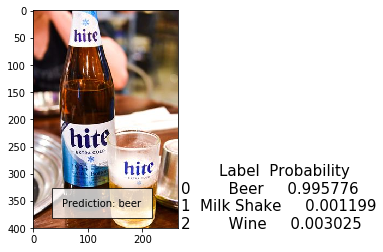

In [49]:
get_prediction('./photos/4Ns7n1-jS1gpiwHTQgN0fg.jpg') # Actual label: Beer

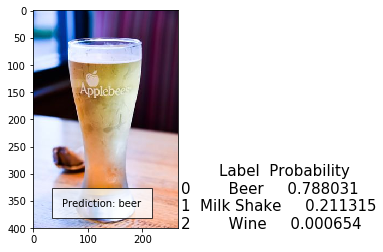

In [57]:
get_prediction('./photos/z5qwtkr6L6xHv-jePVj74A.jpg') # Actual label: Beer

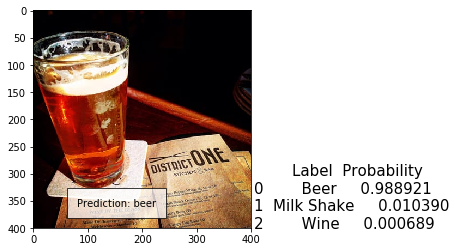

In [64]:
get_prediction('./photos/umE6MwkvCjq66BqDMTqq_w.jpg') # Actual label: Beer

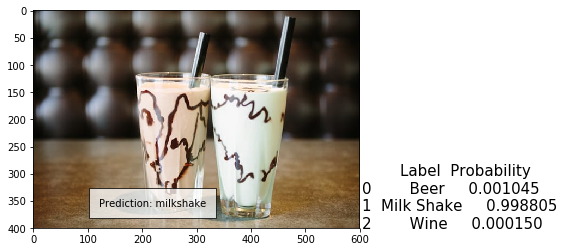

In [68]:
get_prediction('./photos/nVFcMIJRsq4OZzWAGZF5dA.jpg') # Actual label: Milkshake

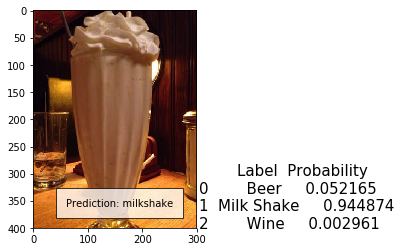

In [52]:
get_prediction('./photos/7xBLqMrOW2JlcLGpnURhJw.jpg') # Actual label: Milkshake

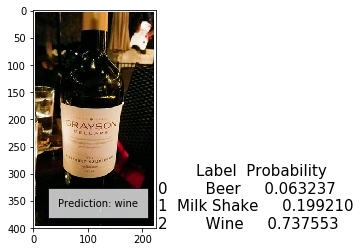

In [54]:
get_prediction('./photos/aDohLNq5hKcFrHEi7qN3rA.jpg') # Actual label: Wine

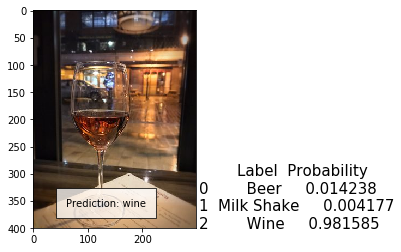

In [69]:
get_prediction('./photos/1mVCyFxREU3vQ-D2kASMlw.jpg') # Actual label: Wine

## Export ResNet50 architecture

In [71]:
model_resnet50_yaml = model_resnet50.to_yaml()
with open("final_model/model_drink.yaml", "w") as yaml_file:
    yaml_file.write(model_resnet50_yaml)